In [36]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.inspection import permutation_importance

In [20]:
icu_data = (
    pd.read_csv("Preprocessed ICU data.csv")
    .rename(columns=lambda col:col.strip())
    .dropna()
)

In [21]:
icu_data

,RecordID,Age,Gender,Height,ICUType2,ICUType3,ICUType4,Mean_Weight.x,Mean_GCS.x,Mean_HR.x,...,Max_ALT.y,Max_AST.y,Max_Bilirubin.y,Max_Lactate.y,Max_Cholesterol.y,Max_TroponinI.y,Max_TroponinT.y,SAPS.I,SOFA,In.hospital_death
0,132543,68,1.0,180.300000,0,1,0,84.600000,14.888889,72.971429,...,12.000000,15.000000,0.200000,2.395461,156.842105,7.132683,1.114629,7,1,0
1,132545,88,0.0,169.787227,0,1,0,83.054136,15.000000,79.520000,...,189.169186,260.323666,1.979557,2.395461,156.842105,7.132683,1.114629,17,2,0
2,132547,64,1.0,180.300000,0,0,0,114.000000,8.333333,81.318182,...,60.000000,162.000000,0.400000,2.395461,212.000000,1.300000,1.114629,14,11,0
3,132551,78,0.0,162.600000,0,1,0,48.400000,13.250000,78.125000,...,46.000000,82.000000,0.300000,2.300000,156.842105,3.500000,1.114629,19,8,1
4,132554,64,0.0,169.787227,0,1,0,60.700000,15.000000,129.363636,...,189.169186,260.323666,1.979557,2.395461,156.842105,7.132683,1.114629,11,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1469,142661,89,1.0,177.800000,0,0,1,64.000000,11.214286,86.260870,...,189.169186,260.323666,1.979557,2.395461,156.842105,7.132683,1.114629,6,4,0
1470,142662,86,1.0,162.600000,0,1,0,53.000000,13.000000,85.517241,...,28.000000,35.000000,0.900000,2.395461,156.842105,7.132683,1.114629,19,8,0
1471,142664,51,0.0,169.787227,0,0,1,75.000000,9.909091,91.147059,...,189.169186,260.323666,1.979557,2.395461,156.842105,7.132683,1.114629,13,8,0
1472,142665,70,0.0,169.787227,0,0,1,87.000000,10.833333,101.083333,...,189.169186,260.323666,1.979557,1.100000,156.842105,7.132683,1.114629,19,7,0


<Axes: xlabel='Age', ylabel='Count'>

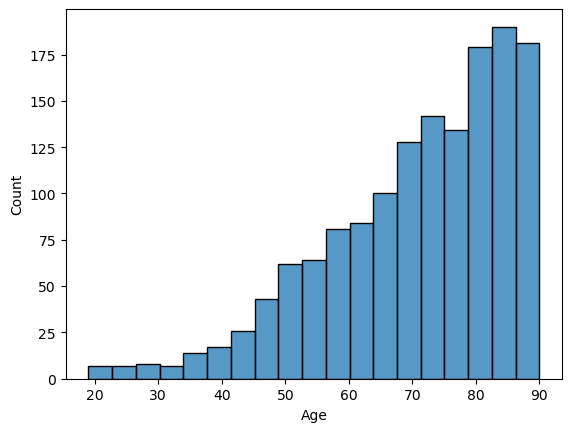

In [22]:
sns.histplot(icu_data, x="Age")

<Axes: xlabel='Gender', ylabel='Count'>

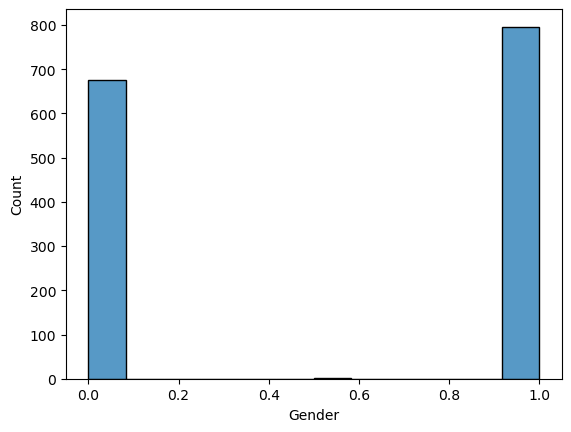

In [23]:
sns.histplot(icu_data, x="Gender")

<Axes: xlabel='Age', ylabel='Height'>

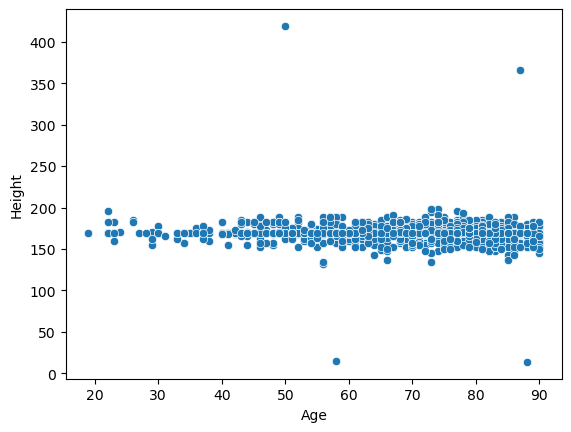

In [24]:
sns.scatterplot(icu_data, x="Age", y="Height")

In [25]:
corr_data = icu_data[['Gender', 'Age', 'Height', 'SAPS.I', 'SOFA', 'In.hospital_death']]
corr_data.corr()

,Gender,Age,Height,SAPS.I,SOFA,In.hospital_death
Gender,1.000000,-0.086683,0.267399,0.013460,0.090226,0.002713
Age,-0.086683,1.000000,-0.084569,0.109284,-0.087250,-0.046584
Height,0.267399,-0.084569,1.000000,-0.008925,0.011080,0.001863
SAPS.I,0.013460,0.109284,-0.008925,1.000000,0.535419,0.167370
SOFA,0.090226,-0.087250,0.011080,0.535419,1.000000,0.225708
In.hospital_death,0.002713,-0.046584,0.001863,0.167370,0.225708,1.000000


In [26]:
icu_x = icu_data.filter(regex="x$",axis=1)
icu_x

,Mean_Weight.x,Mean_GCS.x,Mean_HR.x,Mean_NIDiasABP.x,Mean_NIMAP.x,Mean_NISysABP.x,Mean_RespRate.x,Mean_Temp.x,Mean_Urine.x,Mean_BUN.x,...,Max_SaO2.x,Max_Albumax.x,Max_ALP.x,Max_ALT.x,Max_AST.x,Max_Bilirubin.x,Max_Lactate.x,Max_Cholesterol.x,Max_TroponinI.x,Max_TroponinT.x
0,84.600000,14.888889,72.971429,65.970588,84.951471,122.911765,15.818182,36.214286,466.666667,21.5,...,97.487151,4.400000,105.00000,12.000000,15.000000,0.200000,2.984208,156.684211,8.147317,1.271183
1,83.054136,15.000000,79.520000,49.333333,78.748095,137.571429,19.720000,37.000000,59.800000,45.0,...,97.487151,3.300000,107.83955,193.006395,294.350348,1.980606,2.984208,156.684211,8.147317,1.271183
2,114.000000,8.333333,81.318182,70.500000,81.985000,105.000000,19.666415,37.100000,237.500000,17.0,...,97.000000,3.009175,101.00000,60.000000,162.000000,0.400000,2.984208,212.000000,1.300000,1.271183
3,48.400000,13.250000,78.125000,28.000000,54.499545,107.500000,19.666415,37.133333,51.210526,69.0,...,97.000000,1.900000,47.00000,46.000000,82.000000,0.300000,2.000000,156.684211,3.500000,1.271183
4,60.700000,15.000000,129.363636,65.454545,85.605455,125.909091,35.409091,37.040000,233.333333,21.0,...,97.487151,3.009175,107.83955,193.006395,294.350348,1.980606,2.984208,156.684211,8.147317,1.271183
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1469,64.000000,11.214286,86.260870,60.041667,82.788333,128.291667,19.565217,37.000000,116.470588,12.5,...,97.487151,3.600000,107.83955,193.006395,294.350348,1.980606,2.984208,156.684211,8.147317,1.271183
1470,53.000000,13.000000,85.517241,40.576271,67.541695,121.474576,19.666415,37.166667,67.142857,57.0,...,97.487151,2.600000,192.00000,35.000000,37.000000,1.100000,2.984208,156.684211,8.147317,1.271183
1471,75.000000,9.909091,91.147059,57.213827,75.982764,116.454270,19.666415,36.812500,120.318182,9.5,...,98.000000,3.009175,107.83955,193.006395,294.350348,1.980606,2.984208,156.684211,8.147317,1.271183
1472,87.000000,10.833333,101.083333,60.400000,75.733000,106.400000,19.666415,36.642857,57.823529,14.0,...,97.487151,3.009175,107.83955,193.006395,294.350348,1.980606,3.000000,156.684211,8.147317,1.271183


In [27]:
icu_y = icu_data.filter(regex="y$",axis=1)
icu_y

,Mean_Weight.y,Mean_GCS.y,Mean_HR.y,Mean_NIDiasABP.y,Mean_NIMAP.y,Mean_NISysABP.y,Mean_RespRate.y,Mean_Temp.y,Mean_Urine.y,Mean_BUN.y,...,Max_SaO2.y,Max_Albumax.y,Max_ALP.y,Max_ALT.y,Max_AST.y,Max_Bilirubin.y,Max_Lactate.y,Max_Cholesterol.y,Max_TroponinI.y,Max_TroponinT.y
0,84.600000,15.000000,68.200000,63.750000,82.375417,119.625000,15.000000,36.233333,625.000000,10.0,...,97.151955,4.400000,105.000000,12.000000,15.000000,0.200000,2.395461,156.842105,7.132683,1.114629
1,83.308061,15.000000,70.000000,42.272727,71.317727,129.409091,18.565217,36.640000,64.722222,25.0,...,97.151955,3.300000,105.561871,189.169186,260.323666,1.979557,2.395461,156.842105,7.132683,1.114629
2,114.000000,8.888889,94.880000,70.500000,81.985000,105.000000,19.648290,37.816667,68.888889,16.5,...,98.000000,2.974458,101.000000,60.000000,162.000000,0.400000,2.395461,212.000000,1.300000,1.114629
3,48.400000,9.600000,65.341463,33.523810,55.888571,100.619048,19.648290,36.980000,36.000000,58.0,...,98.000000,1.900000,47.000000,46.000000,82.000000,0.300000,2.300000,156.842105,3.500000,1.114629
4,60.700000,15.000000,125.291667,63.583333,83.443333,123.166667,34.500000,36.760000,250.000000,23.0,...,97.151955,2.974458,105.561871,189.169186,260.323666,1.979557,2.395461,156.842105,7.132683,1.114629
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1469,64.000000,10.777778,85.833333,61.166667,87.071667,138.888889,19.555556,36.825000,159.062500,14.0,...,97.151955,3.600000,105.561871,189.169186,260.323666,1.979557,2.395461,156.842105,7.132683,1.114629
1470,53.000000,14.666667,77.869565,45.750000,71.499500,123.000000,19.648290,36.716667,71.545455,69.0,...,97.151955,2.600000,155.000000,28.000000,35.000000,0.900000,2.395461,156.842105,7.132683,1.114629
1471,75.000000,10.000000,102.458333,57.441366,76.579340,117.843210,19.648290,37.250000,154.583333,15.0,...,98.000000,2.974458,105.561871,189.169186,260.323666,1.979557,2.395461,156.842105,7.132683,1.114629
1472,87.000000,14.750000,97.642857,68.100000,85.967000,121.700000,19.648290,37.185714,45.318182,18.0,...,97.151955,2.974458,105.561871,189.169186,260.323666,1.979557,1.100000,156.842105,7.132683,1.114629


In [28]:
sample_1 = icu_data.sample(n=10, axis=1)
corr_1 = sample_1.corr()

In [29]:
max_sample1 = corr_1.replace(1, None).max().max()

In [30]:
sample_1.any(axis=1).idxmax()

0

In [32]:
k=int(np.sqrt(len(icu_data)/2))

X = icu_data.drop(columns=["RecordID"])

kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(X)

labels = kmeans.labels_
representatives = []
for cluster_id in range(k):
    cluster_points = X[labels == cluster_id]
    centroid = kmeans.cluster_centers_[cluster_id]
    closest_idx = np.argmin(((cluster_points - centroid)**2).sum(axis=1))
    representatives.append(cluster_points.iloc[closest_idx])

reduced_data = pd.DataFrame(representatives, columns=X.columns)

In [34]:
reduced_data

,Age,Gender,Height,ICUType2,ICUType3,ICUType4,Mean_Weight.x,Mean_GCS.x,Mean_HR.x,Mean_NIDiasABP.x,...,Max_ALT.y,Max_AST.y,Max_Bilirubin.y,Max_Lactate.y,Max_Cholesterol.y,Max_TroponinI.y,Max_TroponinT.y,SAPS.I,SOFA,In.hospital_death
35,68.0,1.0,169.787227,0.0,1.0,0.0,70.400000,15.000000,101.000000,59.428571,...,27.000000,41.000000,0.400000,4.900000,156.842105,7.132683,1.640000,-1.0,1.0,0.0
1371,68.0,1.0,170.200000,0.0,0.0,0.0,87.740299,9.400000,73.710526,60.277778,...,321.000000,8800.000000,1.400000,12.400000,156.842105,7.132683,0.620000,-1.0,15.0,1.0
61,56.0,1.0,169.787227,0.0,1.0,0.0,90.759494,4.285714,114.627907,86.000000,...,1475.000000,5438.000000,18.300000,25.800000,156.842105,7.132683,1.480000,31.0,22.0,1.0
507,70.0,1.0,169.787227,0.0,1.0,0.0,89.000000,8.000000,74.375000,53.105263,...,189.169186,260.323666,1.979557,2.395461,156.842105,7.132683,1.114629,-1.0,-1.0,0.0
878,44.0,0.0,170.200000,0.0,0.0,0.0,99.485714,4.300000,132.230769,57.213827,...,4940.000000,15680.000000,0.500000,10.500000,156.842105,7.132683,2.180000,24.0,16.0,1.0
388,63.0,1.0,169.787227,0.0,1.0,0.0,149.000000,6.375000,114.548387,55.444444,...,2617.000000,1444.000000,1.400000,1.900000,156.842105,7.132683,1.114629,18.0,15.0,0.0
104,60.0,1.0,169.787227,0.0,1.0,0.0,118.400000,3.250000,123.706897,38.736842,...,8126.000000,18430.000000,13.100000,24.100000,156.842105,7.132683,0.080000,33.0,22.0,1.0
375,71.0,1.0,182.900000,1.0,0.0,0.0,123.034921,8.000000,87.928571,41.333333,...,3633.000000,4288.000000,0.900000,9.500000,156.842105,7.132683,1.114629,25.0,11.0,0.0
484,22.0,0.0,169.787227,0.0,1.0,0.0,65.532813,11.166667,130.319149,57.500000,...,3867.000000,4522.000000,5.800000,5.500000,88.000000,7.132683,1.114629,20.0,10.0,1.0
81,72.0,0.0,157.500000,1.0,0.0,0.0,61.575000,4.400000,100.304348,46.250000,...,3599.000000,9820.000000,2.900000,5.500000,174.000000,7.132683,1.114629,28.0,14.0,0.0


In [40]:
X = icu_data.drop(columns=["In.hospital_death", "RecordID"])
Y = icu_data["In.hospital_death"].values

In [55]:
k = 40
topk = perm_df.query("perm_importance_mean > 0").head(k)["feature"].tolist()
X_top_train = X_train[topk]
X_top_test  = X_test[topk]

# Refit a compact model
pipe_small = Pipeline(steps=[
    ("prep", SimpleImputer(strategy="median")),
    ("rf", RandomForestClassifier(
        n_estimators=600, max_depth=None,
        min_samples_split=10, min_samples_leaf=5,
        max_features="sqrt", class_weight="balanced",
        n_jobs=-1, random_state=42
    ))
])

pipe_small.fit(X_top_train, y_train)
pred_small = pipe_small.predict_proba(X_top_test)[:, 1]
print("ROC-AUC with top-k features:", roc_auc_score(y_test, pred_small))

ROC-AUC with top-k features: 0.8101970597435094


In [61]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=42, stratify=Y)

rf = RandomForestClassifier(n_estimators=500, random_state=42)
rf.fit(X_train, Y_train)

print("Training accuracy:", rf.score(X_train, Y_train))
print("Test accuracy:", rf.score(X_test, Y_test))

Training accuracy: 1.0
Test accuracy: 0.7262872628726287


In [67]:
impurity_importance = pd.DataFrame({
    "feature": X.columns,
    "importance_impurity": rf.feature_importances_
}).sort_values("importance_impurity", ascending=False)

print(impurity_importance.head(20))

           feature  importance_impurity
118     Mean_GCS.y             0.036772
192      Max_GCS.y             0.028268
155      Min_GCS.y             0.020195
7       Mean_GCS.x             0.014064
119      Mean_HR.y             0.011815
81       Max_GCS.x             0.009573
82        Max_HR.x             0.009231
125   Mean_Urine.y             0.008866
172      Min_WBC.y             0.008515
143  Mean_SysABP.y             0.008497
193       Max_HR.y             0.008362
32   Mean_SysABP.x             0.008360
156       Min_HR.y             0.007755
187  Min_Lactate.y             0.007614
209      Max_WBC.y             0.007492
135     Mean_WBC.y             0.007424
217   Max_SysABP.y             0.007376
8        Mean_HR.x             0.007343
14    Mean_Urine.x             0.007193
202  Max_Glucose.y             0.007163


In [71]:
perm = permutation_importance(
    rf, X_test, y_test, 
    n_repeats=10,     # how many times to shuffle
    scoring="roc_auc",# metric: how much AUC drops
    random_state=42
)

perm_importance = pd.DataFrame({
    "feature": X.columns,
    "importance_perm": perm.importances_mean,
    "std": perm.importances_std
}).sort_values("importance_perm", ascending=False)

print(perm_importance.head(20))

             feature  importance_perm       std
118       Mean_GCS.y         0.013148  0.003711
192        Max_GCS.y         0.009958  0.005192
155        Min_GCS.y         0.004163  0.002493
202    Max_Glucose.y         0.001958  0.001065
209        Max_WBC.y         0.001935  0.001636
87        Max_Temp.x         0.001900  0.000369
200        Max_BUN.y         0.001713  0.000661
172        Min_WBC.y         0.001681  0.001281
62          Min_pH.x         0.001505  0.000374
157  Min_NIDiasABP.y         0.001456  0.000392
95   Max_Platelets.x         0.001268  0.000310
148       Mean_AST.y         0.001257  0.000692
89         Max_BUN.x         0.001256  0.000407
13       Mean_Temp.x         0.001253  0.000504
187    Min_Lactate.y         0.001225  0.001043
76     Min_Lactate.x         0.001192  0.000677
14      Mean_Urine.x         0.001093  0.001331
173         Min_pH.y         0.001068  0.000488
186  Min_Bilirubin.y         0.001065  0.000758
136        Mean_pH.y         0.001046  0